## E01 : Search Algorithms (BFS, DFS, Dijkstra's, A*)

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from classes.Stack import Stack
from classes.Queue import Queue
from classes.PriorityQueue import PriorityQueue
from typing import Union
import networkx as nx
import pandas as pd
import numpy as np
import string
import math
import glob


#### **E1.01 :** Manually solve the following maze

<img src='imgs/e1.01_maze.png' alt='Maze' width='200' height='auto'>
<img src='imgs/e1.01_solved.png' alt='Solved Maze' width='200' height='auto'>

#### **E1.02 :** Read `maze_0x.csv` files and display information visually

In [69]:
# Maps 0 | 1 | 2 values into White, Gray and Orange, respectively
cmap = ListedColormap(['white', 'gray', 'orange', 'green'])
maze_path = 'datasets/*.csv'
maze_dict = {}

csv_files = enumerate(glob.glob(maze_path))
for file_path in csv_files:
    var_name = file_path[1].split('/')[1].split('.')[0]
    maze_dict[var_name] = pd.read_csv(file_path[1], header=None).to_numpy()

In [3]:
def maze_plotter(data: np.ndarray):
    """
    A helper function to plot 2D data into a maze
    """
    im = plt.imshow(data[::], interpolation='none', vmin=0, vmax=3, aspect='equal', cmap=cmap)

    # Get the axis
    ax=plt.gca()                            

    # Major ticks
    ax.set_xticks(np.arange(0, data.shape[1], 1))
    ax.set_yticks(np.arange(0, data.shape[0], 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, data.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, data.shape[0], 1), minor=True)

    # Invert the axis
    ax.set_ylim(ax.get_ylim()[::])  
    ax.set_xlim(ax.get_xlim()[::])      
    ax.xaxis.tick_top()                         

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    return im

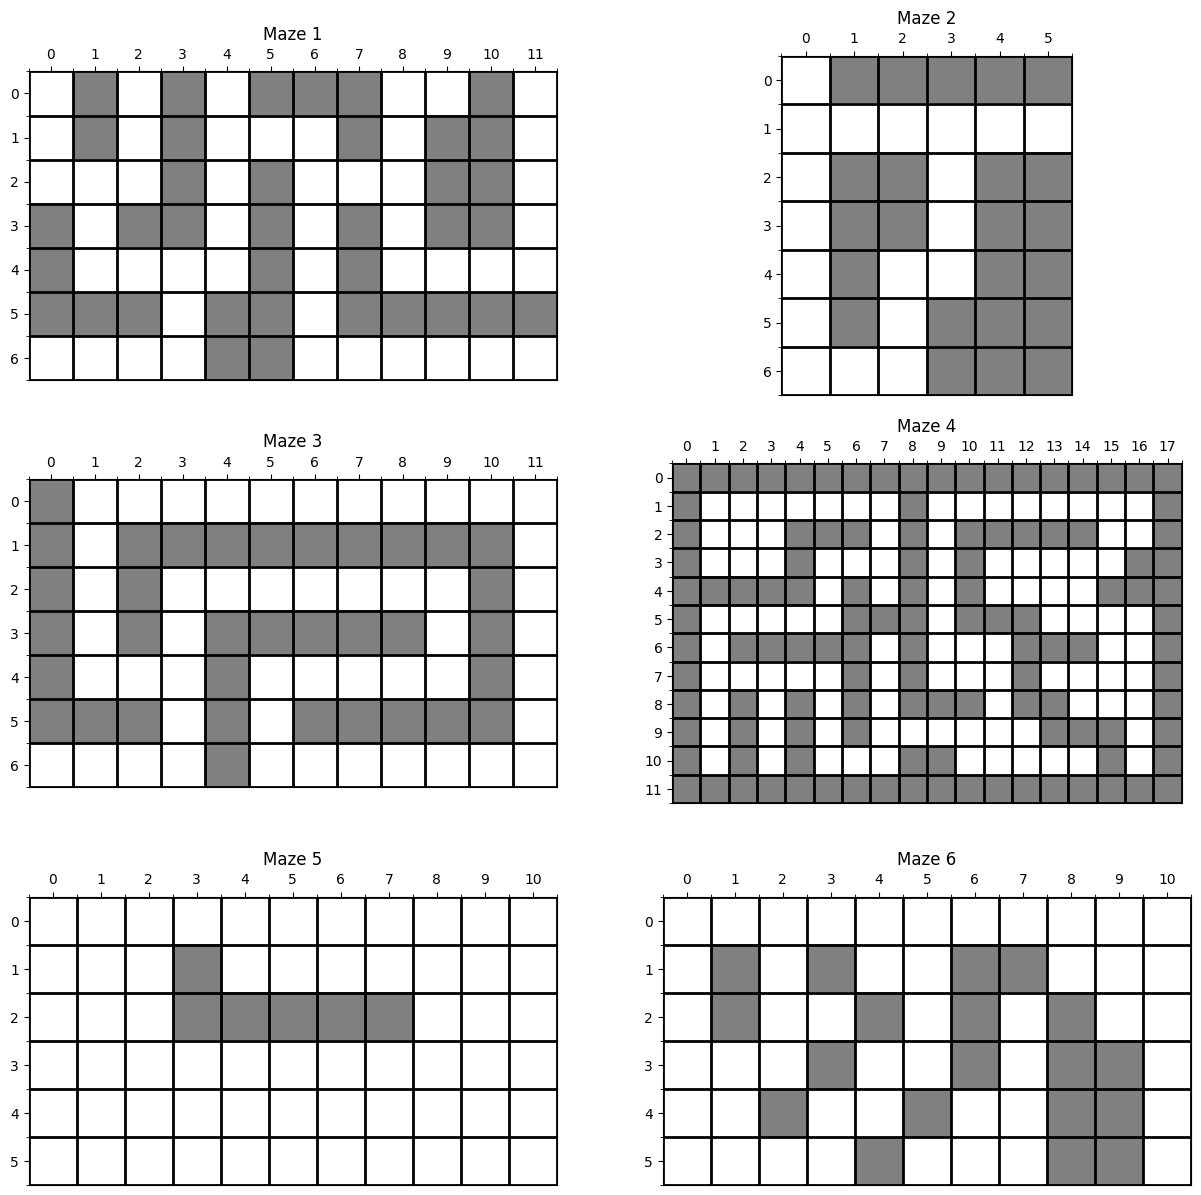

In [70]:
fig = plt.figure(figsize=(15,15))
rows = 3; cols = 2

for maze_num in range(1, len(maze_dict)+1):
    fig.add_subplot(rows, cols, maze_num)
    maze_plotter(maze_dict[f'maze_0{maze_num}'])
    plt.title(f'Maze {maze_num}')

#### **E1.03 & E1.04 :** Implement BFS (Breathe First Search) and DFS (Depth First Search) as a single algorithm
- Display visited states registered at $Q$
- Visually color states visited
- Algorithm is able to receive a Stack and Queue as $Q$

*Support Functions*  
**f(x,u)** -> Get state $x'$ after executing action $u$ in state $x$  
**U(x)** -> Get valid action space respecting state $x$  
**get_index()** -> Maps state to maze index

In [6]:
"""
Agent Actions (Clockwise):
- Up : (x-1, y)
- NorthEast : (x-1, y+1)
- Right : (x, y+1)
- SouthEast : (x+1, y+1)
- Down : (x+1, y)
- SouthWest : (x+1, y-1)
- Left : (x, y-1)
- NorthWest : (x-1, y-1)
"""

def f(x: tuple, u: tuple):
    return tuple(np.add(x,u))

# Von Neuman Neighborhood (4 Moves)
def U(state: tuple, maze_dim: tuple) -> np.ndarray:
    U = []
    if not (state[0] - 1 < 0): U.append((-1,0))               # Move Up
    if not (state[1] + 1 > maze_dim[1] - 1): U.append((0,1))  # Move Right
    if not (state[0] + 1 > maze_dim[0] - 1): U.append((1,0))  # Move Down
    if not (state[1] - 1 < 0): U.append((0,-1))               # Move Left
    return np.array(U)

# Moore's Neighborhood (8 Moves)
def Um(state: tuple, maze_dim: tuple) -> np.ndarray:
    U = []
    # Move North (Up)
    if not (state[0] - 1 < 0): U.append((-1,0))
    # Move NorthEast
    if not (state[0] - 1 < 0) and not (state[1] + 1 > maze_dim[1] - 1): U.append((-1, 1))  
    # Move East (Right)
    if not (state[1] + 1 > maze_dim[1] - 1): U.append((0,1))  
    # Move SouthEast 
    if not (state[0] + 1 > maze_dim[0] - 1) and not (state[1] + 1 > maze_dim[1] - 1): U.append((1, 1))
    # Move South (Down)
    if not (state[0] + 1 > maze_dim[0] - 1): U.append((1,0))
    # Move SouthWest
    if not (state[0] + 1 > maze_dim[0] - 1) and not (state[1] - 1 < 0): U.append((1, -1))                              
    # Move West (Left)
    if not (state[1] - 1 < 0): U.append((0,-1))
    # Move NorthWest
    if not (state[0] - 1 < 0) and not (state[1] - 1 < 0): U.append((-1,-1))                              
    return np.array(U)

def get_index(state: tuple, maze_dim: tuple):
    return (state[0] * (maze_dim[1])) + state[1]

In [7]:
def BDFS(Q: Union[Stack, Queue], init_x: tuple, target_x: tuple, maze_data: np.ndarray) -> dict:
    # Dict that contains maze information
    mi = {
        'maze_dim': maze_data.shape,        # Calculate maze index and Set maze constraints
        'status': False,                    # Tells whether target_x has a solution
        'visited_x': [],                    # Stores visited states
        'visited_m':np.copy(maze_data),     # Maze copy to mark visited states
        'cells_table': {}}

    # Either init or target state is a forbidden cell
    if maze_data[init_x[0],init_x[1]] or maze_data[target_x[0],target_x[1]] == 1:
        return mi

    # BDFS Start
    Q.insert(init_x); mi['visited_m'].put(get_index(init_x, mi['maze_dim']), 2)
    mi['visited_x'].append(init_x) 

    # Border has valid states
    while Q.size() != 0:
        # Get Current State 
        x = Q.get_first()
        mi['cells_table'][x] = [x, math.inf, None]
        
        # Current state matches target state | SUCCESS
        if x[0] == target_x[0] and x[1] == target_x[1]:
            mi['cells_table'][x] = [x, math.inf, None]
            mi['status'] = True; return mi
        
        # Explores action space
        for u in U(x, mi['maze_dim']):
            next_x = f(x,u)
            if mi['visited_m'][next_x[0],next_x[1]] == 2: continue
            elif mi['visited_m'][next_x[0],next_x[1]] == 0:
                mi['visited_m'].put(get_index(next_x, mi['maze_dim']), 2)
                mi['visited_x'].append(next_x); mi['cells_table'][next_x] = [next_x, math.inf, None]
                Q.insert(next_x)

    # Border doesn't have any valid state | FAILURE
    return mi 

**Side-by-Side Comparison: BFS and DFS on Maze 2**

In [ ]:
borders = [Queue(), Stack()]
fig = plt.figure(figsize=(10,10))
fig.suptitle("Side-by-Side Comparison: BFS and DFS with Maze 2", y=0.8)
rows = 1; cols = 2

for idx, dsa in enumerate(borders, start=1):
    fig.add_subplot(rows, cols, idx)
    maze_info = BDFS(dsa, (6,0), (3,3), maze_dict['maze_02'])
    print(f"Maze 02 has solution to target state? : {maze_info['status']}")
    print(f"Visited States at Q :")
    [print(maze_info['visited_x'][x], end=" ") if (x+1)%4 else print(maze_info['visited_x'][x]) for x in range(len(maze_info['visited_x']))]
    print(f"Number of Visited States: {len(maze_info['visited_x'])}\n")
    maze_plotter(maze_info['visited_m'])
    plt.title("DFS" if type(dsa) == Stack else "BFS")

**Row-by-Row Comparison: BFS and DFS on All Mazes**

In [ ]:
fig = plt.figure(figsize=(20,20))
rows = 2; cols = 4; counter = 1
init_state = (6,0); target_state = (3,3)
fig.suptitle("Row-by-Row Comparison: BFS and DFS on all Mazes", y=0.85)

for dsa in borders:
    print("\033[1mDFS\033[0m") if type(dsa) == Stack else print("\033[1mBFS\033[0m") 
    for maze_num in range(1, len(maze_dict)): # Add +1 to len(maze_dict) when using 4 mazes
        fig.add_subplot(rows, cols, counter)
        if type(dsa) == Stack: q = Stack(); 
        else: q = Queue()
        mi = BDFS(q, init_state, target_state, maze_dict[f'maze_0{maze_num}'])
        print(f"Maze 0{maze_num} has solution to target state? : {mi['status']}")
        print(f"Visited States at Q :")
        [print(mi['visited_x'][x], end=" ") if (x+1)%8 else print(mi['visited_x'][x]) for x in range(len(mi['visited_x']))]; print("\n")
        maze_plotter(mi['visited_m'])
        plt.title(f"Maze {maze_num} DFS" if type(dsa) == Stack else f"Maze {maze_num} BFS")
        plt.tight_layout()
        counter += 1

plt.show()


#### **E1.05:** Given the following graph, manually employ Dijkstra's Algorithm to find the shortest path from node 'a' to 'e'.
<img src='imgs/e1.05_graph.png' alt='Grafo Ejercicio 1.05' height=200 width=200>

**Solution:**  
  
<img src='imgs/e1.05_solved.png' alt='Ejercicio 1.05 Resuelto' height=500 width=500>

#### **E1.06:** Given the following graph, manually employ Dijkstra's Algorithm to find the shortest path from node 'a' to 'z'.
<img src='imgs/e1.06_graph.png' alt='Grafo Ejercicio 1.06' height=250 width=200>



**Solution:**  
  
<img src='imgs/e1.06_solved.png' alt='Ejercicio 1.06 Resuelto' height=500 width=500>

#### **E1.07:** Given the following graph, manually employ Dijkstra's Algorithm to find the shortest path from node 'a' to 'z'.
<img src='imgs/e1.07_graph.png' alt='Grafo Ejercicio 1.07' height=200 width=200>

**Solution:**

|Vertex|Shortest Path|Previous Vertex
|------|-------------|----------------|
|a|0|-|
|b|$\cancel{\infty}$ 4|a|
|c|$\cancel{\infty}$ 3|a|
|d|$\cancel{\infty}$ 10|c|
|e|$\cancel{\infty}$ ~~13~~ 12|$\cancel{c}$ d|
|f|$\cancel{\infty}$ 9|b|
|z|$\cancel{\infty}$ 17|e|

**Path:** $a\rightarrow c \rightarrow d \rightarrow e \rightarrow z$  
**Final Cost:** $17$


#### **E1.08:** Implement Dijsktra's Algorithm on Maze
- Display shortest path node-by-node 
- Display final cost
- Visually color vertex that corresponds to shortest path

**$L_{1}$ Norm or Manhattan Distance**. Es la suma de las magnitudes de los vectores en un espacio. En esta norma, todos los componentes del vector se ponderan por igual.  
$L_{1} = \left | x_{1}-x_{2}  \right | + \left | y_{1}-y_{2}  \right |$

In [8]:
def manhattan_distance(p1:tuple, p2:tuple) -> int:
    return np.abs(p1[0] - p2[0]) + np.abs(p1[1] - p2[1])

In [56]:
def dijsktra_maze(Q: Union[Queue], init_x: tuple, target_x: tuple, maze_data: np.ndarray) -> dict:
    # Execute BDFS algorithm to fill maze states table
    mi = BDFS(Queue(), init_x, target_x, maze_data)
    # If BDFS search fails it retuns a False status on Maze Solution
    if mi['status'] == False: return mi

    # Update maze information from dictionary
    mi['status'] = False; mi['visited_x'] = []; mi['cells_table'][init_x][1] = 0
    mi['shortest_path'] = []; mi['final_cost'] = 0

    # Dijsktra Start
    Q.insert(init_x); mi['visited_x'].append(init_x)

    while Q.size() != 0:
        # Gets current state
        x = Q.get_first()

        # Current state matches target state | SUCCESS
        if x[0] == target_x[0] and x[1] == target_x[1]:
            # Write relevant Dijstra's results to graph dict
            mi['final_cost'] = mi['cells_table'][x][1]; mi['shortest_path'].append(x); mi['status'] = True
            while x[0] != init_x[0] or x[1] != init_x[1]: 
                prev_x = mi['cells_table'][x][2]
                mi['shortest_path'].append(prev_x)
                x = prev_x
            mi['shortest_path'].reverse()
            return mi
        
        # Explores available actions
        for u in U(x, mi['maze_dim']):
            next_x = f(x,u)
            # Ensures the next-state hasn't been visited and isn't a forbidden cell
            if next_x not in mi['visited_x'] and maze_data[next_x[0], next_x[1]] != 1:
                # Performs C(x') calculation based on adjacent state
                C_xnext = mi['cells_table'][x][1] + manhattan_distance(next_x, target_x)
                # Compares C(x') with current state's shortest distance
                if C_xnext < mi['cells_table'][next_x][1]:
                    mi['cells_table'][next_x][1] = C_xnext; mi['cells_table'][next_x][2] = x
                    mi['visited_x'].append(next_x)
                    Q.insert(next_x)
    return mi

In [55]:
def dijsktra_opt_maze(Q: Union[PriorityQueue], init_x: tuple, target_x: tuple, maze_data: np.ndarray) -> dict:
    # Dict that contains maze information
    mi = {
        'maze_dim': maze_data.shape,        # Calculate maze index and Set maze constraints
        'status': False,                    # Tells whether target_x has a solution
        'came_from': {},                    # Keeps track of shortest path's nodes
        'cost_so_far': {},                  # Stores node's C(x) 
        'visited_m':np.copy(maze_data),     # Maze copy to mark visited states
        'iterations':0,                     # Iterations passed until shortest path is found
        'shortest_path': [],                # Node-by-node path to shortest route
        'final_cost': 0}                    # Shortest Path's cost

    # Initialize sub-dicts and insert init state to Frontier
    mi['came_from'][init_x] = None; mi['cost_so_far'][init_x] = 0
    Q.put(init_x, 0); mi['visited_m'].put(get_index(init_x, maze_data.shape), 2)

    while Q.size() != 0:
        # Gets current state
        x = Q.get()[1]; mi['iterations'] += 1

        # Current state matches target state | SUCCESS
        if x == target_x:
            # Write relevant Dijstra's results to graph dict
            mi['final_cost'] = mi['cost_so_far'][x]; mi['shortest_path'].append(x); mi['status'] = True
            while x != init_x: 
                prev_x = mi['came_from'][x]
                mi['shortest_path'].append(prev_x)
                x = prev_x
            mi['shortest_path'].reverse()
            return mi
        
        # Explores available actions
        for u in U(x, mi['maze_dim']):
            next_x = f(x,u)
            # Ensures the next-state hasn't been visited and isn't a forbidden cell
            if maze_data[next_x[0], next_x[1]] != 1 and maze_data[next_x[0], next_x[1]] != 2:
                # Performs C(x') calculation based on adjacent state
                C_xnext = mi['cost_so_far'][x] + manhattan_distance(next_x, target_x)
                # Compares C(x') with current state's shortest distance
                if next_x not in mi['cost_so_far'] or C_xnext < mi['cost_so_far'][next_x]:
                    mi['cost_so_far'][next_x] = C_xnext; 
                    Q.put(next_x, C_xnext)
                    mi['visited_m'].put(get_index(next_x, maze_data.shape), 2)
                    mi['came_from'][next_x]= x
    return mi

Maze has solution to target state? : True
Node-by-Node Path: (4, 7) -> (3, 7) -> (3, 8) -> (2, 8) -> (1, 8) -> (1, 7) -> (1, 6) -> (1, 5) -> (1, 4)
Path Length: 9
Shortest Path's Cost: 26


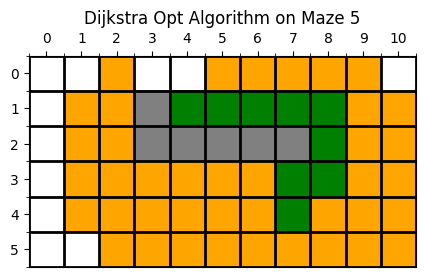

In [43]:
init_x = tuple(int(x) for x in input("Enter Initial State: ").split(" "))
target_x = tuple(int(x) for x in input("Enter Target State: ").split(" "))
maze = input("Select Maze (1 to 5): ")

# Shortest Path is colored Green
fig = plt.figure(figsize=(5,5))
mi = dijsktra_opt_maze(PriorityQueue(), init_x, target_x, maze_dict[f'maze_0{maze}'])
if mi['status'] != False: 
    print(f"Maze has solution to target state? : {mi['status']}")
    # print(f"Iterations to find shortest path: {mi['iterations']}")
    print(f"Node-by-Node Path: {' -> '.join([str(x) for x in mi['shortest_path']])}")
    print(f"Path Length: {len(mi['shortest_path'])}")
    print(f"Shortest Path's Cost: {mi['final_cost']}")
    for x in mi['shortest_path']: mi['visited_m'].put(get_index(x, mi['maze_dim']),3) 
    maze_plotter(mi['visited_m'])
    plt.title(f'Dijkstra Opt Algorithm on Maze {maze}')
else: print(f"Maze {maze} doesn't have a solution")

#### **E1.08.1:** Implement Dijsktra's Algorithm for Adjacency Matrix
- Display shortest path node-by-node 
- Display final cost
- Visually color vertex that corresponds to shortest path

In [ ]:
# Adjancency Matrix from graphs E1.05, E1.06 and E1.07 
graph_e105 = np.array([[0,7,3,0,0],
                       [7,0,1,2,6],
                       [3,1,0,2,0],
                       [0,2,2,0,4],
                       [0,6,0,4,0]])
graph_e106 = np.array([[0,4,2,0,0,0],
                       [4,0,1,5,0,0],
                       [2,1,0,8,10,0],
                       [0,5,8,0,2,6],
                       [0,0,10,2,0,0],
                       [0,0,0,6,5,0]])
graph_e107 = np.array([[0,4,3,0,0,0,0],
                       [4,0,1,0,12,5,0],
                       [3,1,0,7,10,0,0],
                       [0,0,7,0,2,0,0],
                       [0,12,10,2,0,0,5],
                       [0,5,0,0,0,0,16],
                       [0,0,0,0,5,16,0]])

# Creates randoms graph (Experimental)
# adj_matrix = np.random.randint(0,16,size=(6,6))  
# np.fill_diagonal(adj_matrix, 0)

def show_graph(adjancency_matrix:np.ndarray):
    G = nx.from_numpy_array(adjancency_matrix)
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G,"weight")
    nx.draw(G, pos, node_size=200, labels=get_labels(adjancency_matrix.shape), with_labels=True, style='--')
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.show()

def get_labels(adjancency_dims:tuple):
    labels = {index: letter for index, letter in enumerate(string.ascii_lowercase[:adjancency_dims[0]])}
    return labels

show_graph(graph_e105)

*Agent Functions:*
  
**$C(v)$** $\rightarrow$ Get cost from source $src$ to current vertex $v$  
**$l(v,u)$** $\rightarrow$ Get weight from current vertex $v$ to next vertex $v'$  
**$C(v')$** $\rightarrow$ Get cost from source $src$ to next vertex $v'$  

In [ ]:
# Graph Dijsktra Algorithm
def dijsktra(graph:np.ndarray, src:Union[int,str], dst:Union[int,str]) -> dict:
    # Dict that contains graph information
    gi = {
        'status': False,                            # Tells wheter dst has a solution
        'visited_v': [],                            # Stores visited vertex
        'novisited_v': np.arange(graph.shape[0]),   # Stores non-visited vertex
        'shortest_path': [],                        # Node-by-node path to shortest route
        'final_cost': 0}                            # Shortest Path's cost
    
    # Either source or destination node is indicated by an string (label) or int
    src = string.ascii_lowercase.index(src) if type(src) == str else src
    dst = string.ascii_lowercase.index(dst) if type(dst) == str else dst

    # Dijsktra Start 
    vrtx_table = {index:[letter, math.inf, None] for index, letter in enumerate(gi['novisited_v'])}
    vrtx_table[src][1] = 0; v = src 
    
    # Explore the graph until reaching destination vertex
    while len(gi['novisited_v']) != 0:

        # Current state matches target state | SUCCESS
        if v == dst:
            # Write relevant Dijstra's results to graph dict
            gi['final_cost'] = vrtx_table[v][1]; gi['shortest_path'].append(v); gi['status'] = True
            while v != src: prev_v = vrtx_table[v][2]; gi['shortest_path'].append(prev_v); v = prev_v
            gi['shortest_path'].reverse()
            gi['shortest_path'] = [get_labels(graph.shape).get(idx) for idx in gi['shortest_path']]
            return gi
        
        # Explores Adjacent edges from vertex v
        idx_edges = np.nonzero(graph[v,:])[0]; edges_w = []
        for e in idx_edges:
            # Analyze non-visited adjacent vertex
            if e not in gi['visited_v']:
                # Performs C(x') calculation based on adjacent vertex
                C_vnext = vrtx_table[v][1] + graph[v,e]
                # Compares C(x') with current vertex's shortest distance
                if C_vnext < vrtx_table[e][1]:
                    edges_w.append(graph[v,e])
                    vrtx_table[e][1] = C_vnext; vrtx_table[e][2] = v

        # Updates visited and non-visited vertex arrays
        gi['visited_v'].append(v); gi['novisited_v'] = np.delete(gi['novisited_v'],np.where(gi['novisited_v'] == v)[0][0],0); 
        if len(edges_w) == 0: v = dst
        else: v = np.where(graph[v,:] == np.min(np.array(edges_w), 0))[0][0]
            
    # Graph doesn't have any valid vertex | FAILURE
    return gi

In [ ]:
gi = dijsktra(graph_e106, 'f', 'a')
print(f"Graph has result to vertex destination? : {gi['status']}")
print(f"Visited vertex : {gi['visited_v']}")
print(f"Non-Visited vertex: {gi['novisited_v']}")
print(f"Node-by-Node Path: {' -> '.join(gi['shortest_path'])}")
print(f"Shortest Path's Cost: {gi['final_cost']}")

#### **E1.09: Implement $A^{*}$ Algorithm**

The $A^{*}$ Algorithms is an optimization from Dijkstra Algorithm.     
This approach centers on managing an heruistic $f$ which is a   
parameter equal to the sum of two other parameters - $g$ and $h$.  
Where at each step, it picks the cell having the lowest $f$.

Where:  
$g$ Cost $=$ Distance from starting node  
$h$ Cost $=$ Distance from end node  
$f$ Cost $= g + h$  

In [13]:
def is_diagonal(action: tuple):
    return not (action[0] == 0 or action[1] == 0)

In [14]:
# From Sebastian Lague video: Pathfinding #1 - A* Algorithm (Pseudocode)
def a_star(Q: PriorityQueue, init_x: tuple, target_x: tuple, maze_data: np.ndarray) -> dict:
    # Dict that contains maze information
    mi = {
        'maze_dim': maze_data.shape,         # Calculate maze index and Set maze constraints
        'status': False,                     # Tells whether target_x has a solution
        'closed_x': [],                      # Set of Nodes already evaluated
        'open_x': [],                        # Set of nodes to be evaluated
        'visited_m':np.copy(maze_data),      # Maze copy to mark visited states
        'node_table': {}                     # Keep track of nodes with lowest f-value
    }

    # Either init or target state is a forbidden cell
    if maze_data[init_x[0],init_x[1]] or maze_data[target_x[0],target_x[1]] == 1:
        return mi

    # A* Start
    mi['visited_m'].put(get_index(init_x, mi['maze_dim']), 2); mi['open_x'].append(init_x)

    while len(mi['open_x']) != 0:
        for node in mi['open_x']:
            fvalue = manhattan_distance(init_x, node) + manhattan_distance(node, target_x)
            mi['node_table'][node] = fvalue; Q.insert(fvalue)
        # Current in OPEN with the Lowest f_cost
        current = Q.get()
        mi['open_x'].pop()
        mi['closed_x'].append(current)

        # Current state matches target state | SUCCESS
        if x[0] == target_x[0] and x[1] == target_x[1]:
            mi['status'] = True; return mi
        
        # Foreach neighbour of the current node

            # if neighbour is not traversable or neighbour is in CLOSED
                # skip to the next neighbour
        
            # if new path to neighbour is shorter OR neighbour is not in OPEN
                # set f_cost to neighbour
                # set parent of neighbour to current
                # if neighbour is not in OPEN
                    # add neighbour to OPEN

        mi['closed_x'].append()
    
    return mi

In [54]:
def a_estrella(Q: PriorityQueue, init_x: tuple, target_x: tuple, maze_data: np.ndarray) -> dict:
    # Dict that contains maze information
    mi = {
        'maze_dim': maze_data.shape,        # Calculate maze index and Set maze constraints
        'status': False,                    # Tells whether target_x has a solution
        'came_from': {},                    # Keeps track of shortest path's nodes
        'cost_so_far': {},                  # Stores node's C(x) 
        'visited_m':np.copy(maze_data),     # Maze copy to mark visited states
        'iterations':0,                     # Iterations passed until shortest path is found
        'shortest_path': [],                # Node-by-node path to shortest route
        'final_cost': 0}                    # Shortest Path's cost

    # Initialize sub-dicts and insert init state to Frontier
    mi['came_from'][init_x] = None; mi['cost_so_far'][init_x] = 0
    Q.put(init_x, 0); mi['visited_m'].put(get_index(init_x, maze_data.shape), 2)
    
    # A* Start
    while Q.size() != 0:
        # Get State with f-value
        current = Q.get()[1]; mi['iterations'] += 1

        # Current state matches target state | SUCCESS
        if current == target_x:
            mi['status'] = True; mi['shortest_path'].append(current); mi['final_cost'] = mi['cost_so_far'][current]
            while current != init_x: prev_x = mi['came_from'][current]; mi['shortest_path'].append(prev_x); current = prev_x
            mi['shortest_path'].reverse()
            return mi

        # Explores Moore's Neighborhood
        for action in U(current, maze_data.shape):
            next = f(current, action)
            if maze_data[next[0],next[1]] == 1 or maze_data[next[0],next[1]] == 2: continue
            # Tells whether a move is diagonal
            if is_diagonal(action): new_cost = mi['cost_so_far'][current] + manhattan_distance(next, target_x)
            else: new_cost = mi['cost_so_far'][current] + manhattan_distance(next, target_x)
            if next not in mi['cost_so_far'] or new_cost < mi['cost_so_far'][next]:
                mi['cost_so_far'][next] = new_cost
                priority = new_cost + manhattan_distance(next, target_x)
                Q.put(next, priority)
                mi['visited_m'].put(get_index(next, maze_data.shape), 2)
                mi['came_from'][next] = current
    return mi

Maze has solution to target state? : True
Iterations to find shortest path: 14
Node-by-Node Path: (1, 4) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (2, 8) -> (3, 8) -> (3, 7) -> (4, 7)
Path Length: 9
Shortest Path's Cost: 22


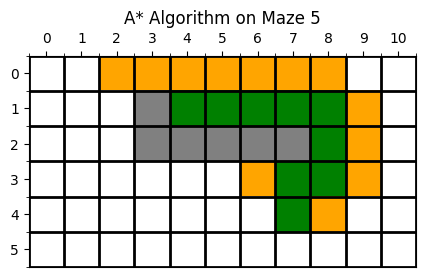

In [65]:
init_x = tuple(int(x) for x in input("Enter Initial State: ").split(" "))
target_x = tuple(int(x) for x in input("Enter Target State: ").split(" "))
maze = input("Select Maze (1 to 5): ")

# Shortest Path is colored Green
fig = plt.figure(figsize=(5,5))
mi = a_estrella(PriorityQueue(), init_x, target_x, maze_dict[f'maze_0{maze}'])
if mi['status'] != False: 
    print(f"Maze has solution to target state? : {mi['status']}")
    print(f"Iterations to find shortest path: {mi['iterations']}")
    print(f"Node-by-Node Path: {' -> '.join([str(x) for x in mi['shortest_path']])}")
    print(f"Path Length: {len(mi['shortest_path'])}")
    print(f"Shortest Path's Cost: {mi['final_cost']}")
    for x in mi['shortest_path']: mi['visited_m'].put(get_index(x, mi['visited_m'].shape),3) 
    maze_plotter(mi['visited_m'])
    plt.title(f'A* Algorithm on Maze {maze}')
else: print(f"Maze {maze} doesn't have a solution")

**Side-by-Side Comparison: BFS Dijkstra vs Dijkstra vs A\***

Maze 06 has solution to target state? : True
Node-by-Node Path: (5, 0) -> (4, 0) -> (3, 0) -> (2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4)
Path Length: 11
Shortest Path's Cost: 37

Maze 06 has solution to target state? : True
Node-by-Node Path: (5, 0) -> (4, 0) -> (3, 0) -> (3, 1) -> (3, 2) -> (2, 2) -> (1, 2) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4)
Path Length: 11
Shortest Path's Cost: 33

Maze 06 has solution to target state? : True
Node-by-Node Path: (5, 0) -> (4, 0) -> (3, 0) -> (3, 1) -> (3, 2) -> (2, 2) -> (1, 2) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4)
Path Length: 11
Shortest Path's Cost: 33



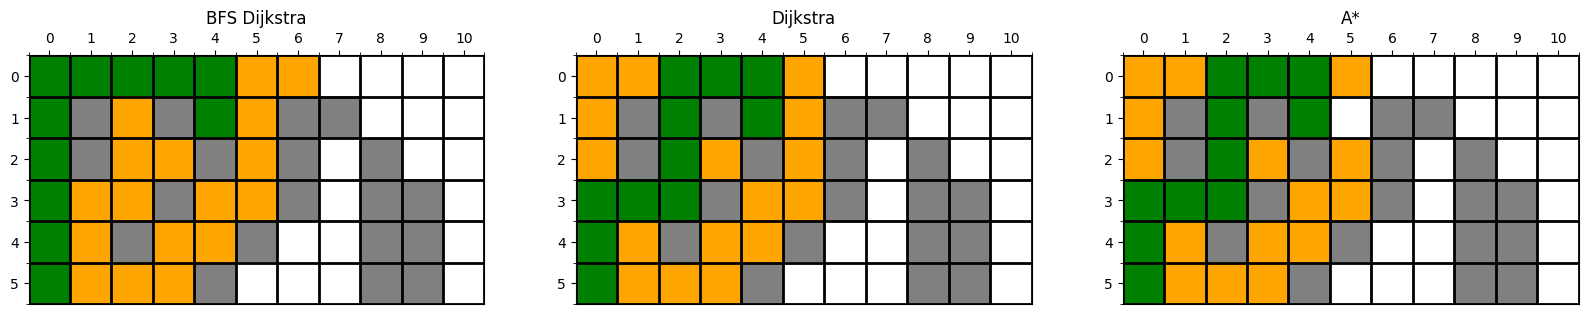

In [72]:
init_x = tuple(int(x) for x in input("Enter Initial State: ").split(" "))
target_x = tuple(int(x) for x in input("Enter Target State: ").split(" "))
maze = input("Select Maze (1 to 5): ")
search_algorithms = [dijsktra_maze, dijsktra_opt_maze, a_estrella]
borders = [Queue(), PriorityQueue(), PriorityQueue()]
names = ['BFS Dijkstra', 'Dijkstra', 'A*']

fig = plt.figure(figsize=(20,20))
rows = 1; cols = 3

for idx, algo in enumerate(search_algorithms, start=1):
    if mi['status'] != False: 
        fig.add_subplot(rows, cols, idx)
        mi = algo(borders[idx-1], init_x, target_x, maze_dict[f'maze_0{maze}'])
        print(f"Maze 0{maze} has solution to target state? : {mi['status']}")
        print(f"Node-by-Node Path: {' -> '.join([str(x) for x in mi['shortest_path']])}")
        print(f"Path Length: {len(mi['shortest_path'])}")
        print(f"Shortest Path's Cost: {mi['final_cost']}\n")
        for x in mi['shortest_path']: mi['visited_m'].put(get_index(x, mi['visited_m'].shape),3) 
        maze_plotter(mi['visited_m'])
        plt.title(names[idx-1])
    else: print(f"Maze {maze} doesn't have a solution")    


#### **E2.12:** Given the following weighted graph, use A\* Algorithm to find the shortest path from node 'a' to 'z'

<img src='imgs/e2.12_graph.png' alt='E2.12 Graph' width=300 height=300>

**Solution:**  
  
<img src='imgs/e2.12_solved.png' alt='E2.12 Graph' width=400 height=400>

#### **E2.13:** Given the following weighted graph, use A\* Algorithm to find the shortest path from node 'a' to 'z'

<img src='imgs/e2.13_graph.png' alt='E2.13 Graph' width=300 height=350>

**Solution:**  

<img src='imgs/e2.13_solved.png' alt='E2.13 Graph' width=400 height=400>